In [ ]:
from google.colab import drive

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")
plt.style.use('dark_background')


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
tf.random.set_seed(333)
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
pd.set_option('display.float_format', lambda x: "{:,.5f}".format(x))
pd.set_option('display.max_columns', None)

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Funciones

In [ ]:
def freq(df, var):
    if type(var) != list:
        var = [var]
    for v in var:
        aux = df[v].value_counts().to_frame().rename(columns={'count':'FA'})
        aux['FR'] = aux['FA'] / aux['FA'].sum()
        aux[['FAA','FRA']] = aux.apply( np.cumsum )
        print(f'Tabla de frecuencias para la variable {v} \n')
        print(aux,'\n')

def norm(df, v, umbral):
    aux = df[v].value_counts(True).to_frame()
    aux[f'n_{v}'] = np.where( aux['proportion'] < umbral , 'CAT_PEQUEÑAS', aux.index )
    valor = aux.head(1)[f'n_{v}'].values[0]
    if aux.loc[aux[f'n_{v}'] == 'CAT_PEQUEÑAS']['proportion'].sum() < umbral:
        aux[f'n_{v}'].replace( {'CAT_PEQUEÑAS':valor} , inplace=True )
    aux.drop('proportion',axis=1, inplace=True)
    aux.reset_index(inplace=True)

    return df.merge(aux, left_on=[v], right_on = [v], how='left').drop(v,axis=1)

def outliers(df):
    descriptive_stats = df.describe(percentiles=[0.01, 0.99])
    higher_99 = []
    lower_01 = []

    # Identificar columnas con valores mayores al percentil 99 o menores al percentil 01
    for col in df.columns:
        max_val = descriptive_stats.loc['max', col]
        percentile_99 = descriptive_stats.loc['99%', col]
        min_val = descriptive_stats.loc['min', col]
        percentile_01 = descriptive_stats.loc['1%', col]

        if max_val > 2 * percentile_99:
            higher_99.append(col)

        if min_val < percentile_01 / 2:
            lower_01.append(col)

    print("Variables cuyo máximo es mayor al doble del percentil 99:", higher_99)
    print("Variables cuyo mínimo es menor a la mitad del percentil 01:", lower_01)

    # Filtrar filas con valores atípicos
    for col in higher_99:
        threshold = descriptive_stats.loc['99%', col]
        df = df[df[col] <= threshold]

    for col in lower_01:
        threshold = descriptive_stats.loc['1%', col]
        df = df[df[col] >= threshold]

    return df

# Lectura de Datos

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Diplomado/Módulo_4/Práctica_1/kch_train_data.csv')
test = pd.read_csv('/content/drive/MyDrive/Diplomado/Módulo_4/Práctica_1/kch_test_data.csv')

In [ ]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,5467910190,20140527T000000,"325,000.00000",3,1.75000,1780,13095,1.00000,0,0,4,9,1780,0,1983,0,98042,47.36700,-122.15200,2750,13095
1,9331800580,20150310T000000,"257,000.00000",2,1.00000,1000,3700,1.00000,0,0,3,6,800,200,1929,0,98118,47.55200,-122.29000,1270,5000
2,2407000405,20150226T000000,"228,500.00000",3,1.00000,1080,7486,1.50000,0,0,3,6,990,90,1942,0,98146,47.48380,-122.33500,1170,7800
3,5466700290,20150108T000000,"288,000.00000",3,2.25000,2090,7500,1.00000,0,0,4,7,1280,810,1977,0,98031,47.39510,-122.17200,1800,7350
4,3026059361,20150417T000000,"479,000.00000",2,2.50000,1741,1439,2.00000,0,0,3,8,1446,295,2007,0,98034,47.70430,-122.20900,2090,10454


In [ ]:
test.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,"365,000.00000",4,2.25000,2070,8893,2.00000,0,0,4,8,2070,0,1986,0,98058,47.43880,-122.16200,2390,7700
1,7974200820,20140821T000000,"865,000.00000",5,3.00000,2900,6730,1.00000,0,0,5,8,1830,1070,1977,0,98115,47.67840,-122.28500,2370,6283
2,7701450110,20140815T000000,"1,038,000.00000",4,2.50000,3770,10893,2.00000,0,2,3,11,3770,0,1997,0,98006,47.56460,-122.12900,3710,9685
3,9522300010,20150331T000000,"1,490,000.00000",3,3.50000,4560,14608,2.00000,0,2,3,12,4560,0,1990,0,98034,47.69950,-122.22800,4050,14226
4,9510861140,20140714T000000,"711,000.00000",3,2.50000,2550,5376,2.00000,0,0,3,9,2550,0,2004,0,98052,47.66470,-122.08300,2250,4050


In [ ]:
test.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [ ]:
um = ['id']
date = ['date']
target = ['price']
var_cont = ['sqft_living','sqft_lot', 'sqft_above', 'sqft_basement']
var_cat = ['bedrooms', 'bathrooms', 'floors','view', 'condition', 'grade', 'yr_built','yr_renovated']
garbage = ['waterfront', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

**Notas.**

* yr_renovated - Crear variable que indique si se ha renovado o no y eliminar ésta
* yr_built - Reducir categorías, agrupar los años de 10 en 10
* grade - Normalizar, ver frequencias
* condition - Normalizar, ver frequencias
* view - Normalizar, ver frequencias
* floors - Normalizar, ver frequencias
* bathrooms - Normalizar, ver frequencias

Las variables de *garbage* no se utilizarán debido a su poca variabilidad o su no importancia en el contexto



# Análisis Exploratorio de Datos

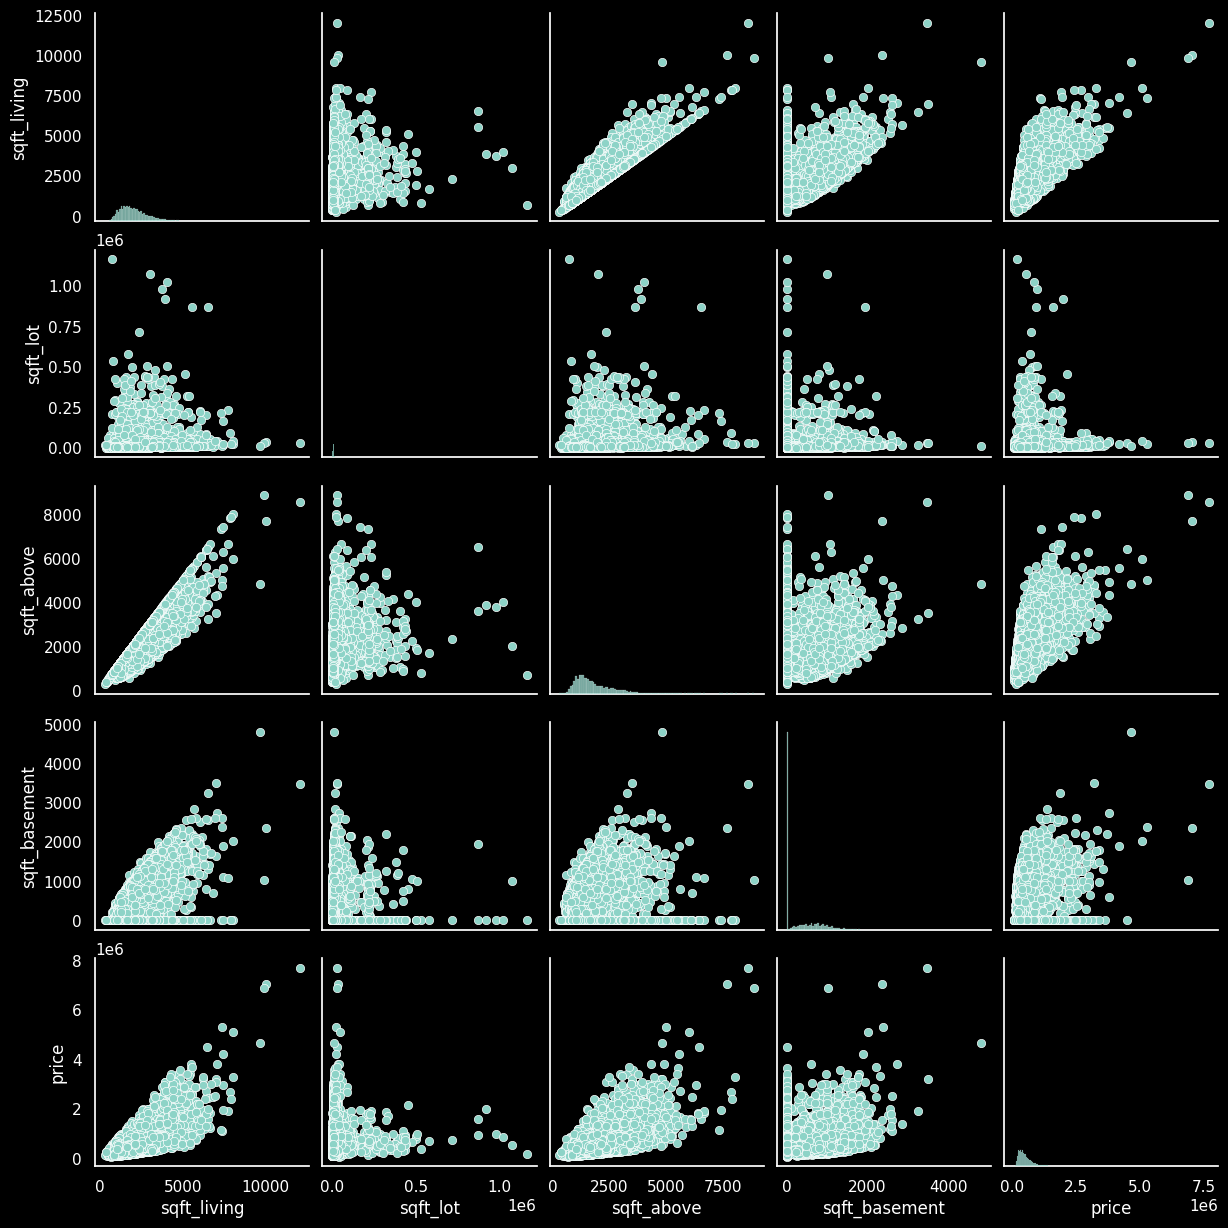

In [ ]:
sns.pairplot(train[var_cont+target]);

In [ ]:
train[var_cont+target].corr()

,sqft_living,sqft_lot,sqft_above,sqft_basement,price
sqft_living,1.00000,0.17626,0.87582,0.42783,0.70170
sqft_lot,0.17626,1.00000,0.18716,0.01402,0.09104
sqft_above,0.87582,0.18716,1.00000,-0.06153,0.60326
sqft_basement,0.42783,0.01402,-0.06153,1.00000,0.32139
price,0.70170,0.09104,0.60326,0.32139,1.00000


Se aprecia que existe una correlación entre algunas de nuestras variables continuas con nuestro target

# Limpieza y Transformación de Datos

## Missings

In [ ]:
test.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [ ]:
train.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## Normalización

In [ ]:
def add_renovated_column(df, column_name='yr_renovated'):
    df['renovated'] = df[column_name].apply(lambda x: 1 if x != 0 else 0)
    return df

In [ ]:
train = add_renovated_column(train)
test = add_renovated_column(test)

In [ ]:
print(train.yr_built.min())
print(test.yr_built.min())
print(train.yr_built.max())
print(test.yr_built.max())

1900
1900
2015
2015


In [ ]:
def group_years(df, column_name='yr_built'):
    bins = list(range(1900, 2021, 20))
    labels = [f'{start}-{start + 19}' for start in bins[:-1]]
    df['year_group'] = pd.cut(df[column_name], bins=bins, labels=labels, right=False)
    return df

In [ ]:
train = group_years(train)
test = group_years(test)

In [ ]:
var_cat = ['bedrooms', 'bathrooms', 'floors', 'view', 'condition', 'grade', 'renovated', 'year_group']

In [ ]:
freq(train, var_cat)

Tabla de frecuencias para la variable bedrooms 

            FA      FR    FAA     FRA
bedrooms                             
3         7865 0.45489   7865 0.45489
4         5477 0.31677  13342 0.77166
2         2237 0.12938  15579 0.90104
5         1292 0.07473  16871 0.97577
6          212 0.01226  17083 0.98803
1          153 0.00885  17236 0.99688
7           29 0.00168  17265 0.99855
8            9 0.00052  17274 0.99907
0            8 0.00046  17282 0.99954
9            5 0.00029  17287 0.99983
10           2 0.00012  17289 0.99994
33           1 0.00006  17290 1.00000 

Tabla de frecuencias para la variable bathrooms 

             FA      FR    FAA     FRA
bathrooms                             
2.50000    4333 0.25061   4333 0.25061
1.00000    3088 0.17860   7421 0.42921
1.75000    2425 0.14025   9846 0.56946
2.25000    1621 0.09375  11467 0.66322
2.00000    1526 0.08826  12993 0.75147
1.50000    1172 0.06778  14165 0.81926
2.75000     963 0.05570  15128 0.87496
3.00000     594 

In [ ]:
for v in var_cat:
    train = norm( train , v , 0.03)
    test = norm( test , v , 0.03)

In [ ]:
varn = [col for col in train.columns if col.startswith('n_')]

In [ ]:
freq(train, varn)

Tabla de frecuencias para la variable n_bedrooms 

              FA      FR    FAA     FRA
n_bedrooms                             
3           8284 0.47912   8284 0.47912
4           5477 0.31677  13761 0.79589
2           2237 0.12938  15998 0.92527
5           1292 0.07473  17290 1.00000 

Tabla de frecuencias para la variable n_bathrooms 

                FA      FR    FAA     FRA
n_bathrooms                              
2.5           4333 0.25061   4333 0.25061
1.0           3088 0.17860   7421 0.42921
1.75          2425 0.14025   9846 0.56946
2.25          1621 0.09375  11467 0.66322
2.0           1526 0.08826  12993 0.75147
1.5           1172 0.06778  14165 0.81926
CAT_PEQUEÑAS   991 0.05732  15156 0.87658
2.75           963 0.05570  16119 0.93227
3.0            594 0.03436  16713 0.96663
3.5            577 0.03337  17290 1.00000 

Tabla de frecuencias para la variable n_floors 

                FA      FR    FAA     FRA
n_floors                                 
1.0           84

In [ ]:
freq(test, varn)

Tabla de frecuencias para la variable n_bedrooms 

              FA      FR   FAA     FRA
n_bedrooms                            
3           2086 0.48254  2086 0.48254
4           1405 0.32501  3491 0.80754
2            523 0.12098  4014 0.92852
5            309 0.07148  4323 1.00000 

Tabla de frecuencias para la variable n_bathrooms 

                FA      FR   FAA     FRA
n_bathrooms                             
2.5           1047 0.24219  1047 0.24219
1.0            764 0.17673  1811 0.41892
1.75           623 0.14411  2434 0.56303
2.25           426 0.09854  2860 0.66158
2.0            404 0.09345  3264 0.75503
1.5            274 0.06338  3538 0.81841
CAT_PEQUEÑAS   250 0.05783  3788 0.87624
2.75           222 0.05135  4010 0.92760
3.0            159 0.03678  4169 0.96438
3.5            154 0.03562  4323 1.00000 

Tabla de frecuencias para la variable n_floors 

                FA      FR   FAA     FRA
n_floors                                
1.0           2192 0.50706  2192 0.5

## Outliers

In [ ]:
train[var_cont].describe(percentiles=[0.01,0.02,0.05,0.5,0.95,0.98,0.99])

,sqft_living,sqft_lot,sqft_above,sqft_basement
count,"17,290.00000","17,290.00000","17,290.00000","17,290.00000"
mean,"2,073.89491","14,798.94737","1,785.96217",287.93274
std,907.29796,"38,839.24851",821.62629,438.72711
min,290.00000,520.00000,290.00000,0.00000
1%,720.00000,"1,005.00000",700.00000,0.00000
2%,790.00000,"1,177.12000",750.00000,0.00000
5%,940.00000,"1,756.00000",850.00000,0.00000
50%,"1,910.00000","7,600.00000","1,560.00000",0.00000
95%,"3,740.00000","42,999.10000","3,380.00000","1,180.00000"
98%,"4,392.20000","103,268.90000","3,950.00000","1,430.00000"


In [ ]:
clean_train = outliers(train[var_cont+target])
train = train.loc[clean_train.index]

Variables cuyo máximo es mayor al doble del percentil 99: ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'price']
Variables cuyo mínimo es menor a la mitad del percentil 01: ['sqft_living', 'sqft_above', 'price']


In [ ]:
clean_test = outliers(test[var_cont+target])
test = test.loc[clean_test.index]

Variables cuyo máximo es mayor al doble del percentil 99: ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'price']
Variables cuyo mínimo es menor a la mitad del percentil 01: []


## Transformación de Datos

In [ ]:
train = pd.get_dummies(train, columns=varn, drop_first=True)
test = pd.get_dummies(test, columns=varn, drop_first=True)

In [ ]:
dummies = ['n_bedrooms_3',
       'n_bedrooms_4', 'n_bedrooms_5', 'n_bathrooms_1.5', 'n_bathrooms_1.75',
       'n_bathrooms_2.0', 'n_bathrooms_2.25', 'n_bathrooms_2.5',
       'n_bathrooms_2.75', 'n_bathrooms_3.0', 'n_bathrooms_3.5',
       'n_bathrooms_CAT_PEQUEÑAS', 'n_floors_1.5', 'n_floors_2.0',
       'n_floors_CAT_PEQUEÑAS', 'n_view_2', 'n_view_CAT_PEQUEÑAS',
       'n_condition_4', 'n_condition_5', 'n_grade_6', 'n_grade_7', 'n_grade_8',
       'n_grade_9', 'n_grade_CAT_PEQUEÑAS', 'n_renovated_1',
       'n_year_group_1920-1939', 'n_year_group_1940-1959',
       'n_year_group_1960-1979', 'n_year_group_1980-1999',
       'n_year_group_2000-2019']

In [ ]:
train[dummies] = train[dummies].astype(int)
test[dummies] = test[dummies].astype(int)

In [ ]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()
scaler_x.fit(train[var_cont])
scaler_y.fit(train[target])

X_train_scaled = scaler_x.transform(train[var_cont])
X_test_scaled = scaler_x.transform(test[var_cont])
y_train_scaled = scaler_y.transform(train[target])
y_test_scaled = scaler_y.transform(test[target])

In [ ]:
train_scaled_df = pd.DataFrame(X_train_scaled, index=train.index, columns=var_cont)
test_scaled_df = pd.DataFrame(X_test_scaled, index=test.index, columns=var_cont)
y_train_scaled_df = pd.DataFrame(y_train_scaled, index=train.index, columns=target)
y_test_scaled_df = pd.DataFrame(y_test_scaled, index=test.index, columns=target)

In [ ]:
train_scaled_df = pd.concat([train_scaled_df, train.drop(columns=var_cont)], axis=1)
test_scaled_df = pd.concat([test_scaled_df, test.drop(columns=var_cont)], axis=1)
y_train_scaled_df = pd.concat([y_train_scaled_df, train.drop(columns=target)], axis=1)
y_test_scaled_df = pd.concat([y_test_scaled_df, test.drop(columns=target)], axis=1)

In [ ]:
train_scaled_df[var_cont+dummies].head()

,sqft_living,sqft_lot,sqft_above,sqft_basement,n_bedrooms_3,n_bedrooms_4,n_bedrooms_5,n_bathrooms_1.5,n_bathrooms_1.75,n_bathrooms_2.0,n_bathrooms_2.25,n_bathrooms_2.5,n_bathrooms_2.75,n_bathrooms_3.0,n_bathrooms_3.5,n_bathrooms_CAT_PEQUEÑAS,n_floors_1.5,n_floors_2.0,n_floors_CAT_PEQUEÑAS,n_view_2,n_view_CAT_PEQUEÑAS,n_condition_4,n_condition_5,n_grade_6,n_grade_7,n_grade_8,n_grade_9,n_grade_CAT_PEQUEÑAS,n_renovated_1,n_year_group_1920-1939,n_year_group_1940-1959,n_year_group_1960-1979,n_year_group_1980-1999,n_year_group_2000-2019
0,-0.31461,0.08897,0.04202,-0.67593,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
1,-1.33037,-0.42553,-1.30743,-0.17910,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,-1.22619,-0.21820,-1.04581,-0.45236,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,0.08909,-0.21743,-0.64648,1.33622,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
4,-0.36540,-0.54935,-0.41790,0.05689,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [ ]:
train_scaled_df[var_cont+dummies].shape

(16336, 34)

# Modelo

## Arquitectura

In [ ]:
X_train = train_scaled_df[var_cont+dummies]
y_train = y_train_scaled_df[target]
X_test = test_scaled_df[var_cont+dummies]
y_test = y_test_scaled_df[target]

In [ ]:
model = Sequential()

model.add(Dense(70, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [ ]:
%%time
model.fit(x=X_train, y=y_train, epochs=500, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stop])

Epoch 1/500
511/511 [==============================] - 3s 3ms/step - loss: 0.8070 - val_loss: 0.5911
Epoch 2/500
511/511 [==============================] - 2s 3ms/step - loss: 0.5546 - val_loss: 0.5142
Epoch 3/500
511/511 [==============================] - 2s 3ms/step - loss: 0.4988 - val_loss: 0.4931
Epoch 4/500
511/511 [==============================] - 2s 4ms/step - loss: 0.4760 - val_loss: 0.4720
Epoch 5/500
511/511 [==============================] - 2s 4ms/step - loss: 0.4650 - val_loss: 0.4610
Epoch 6/500
511/511 [==============================] - 2s 3ms/step - loss: 0.4564 - val_loss: 0.4607
Epoch 7/500
511/511 [==============================] - 2s 3ms/step - loss: 0.4511 - val_loss: 0.4669
Epoch 8/500
511/511 [==============================] - 2s 3ms/step - loss: 0.4511 - val_loss: 0.4588
Epoch 9/500
511/511 [==============================] - 2s 3ms/step - loss: 0.4452 - val_loss: 0.4525
Epoch 10/500
511/511 [==============================] - 2s 3ms/step - loss: 0.4467 - val_lo

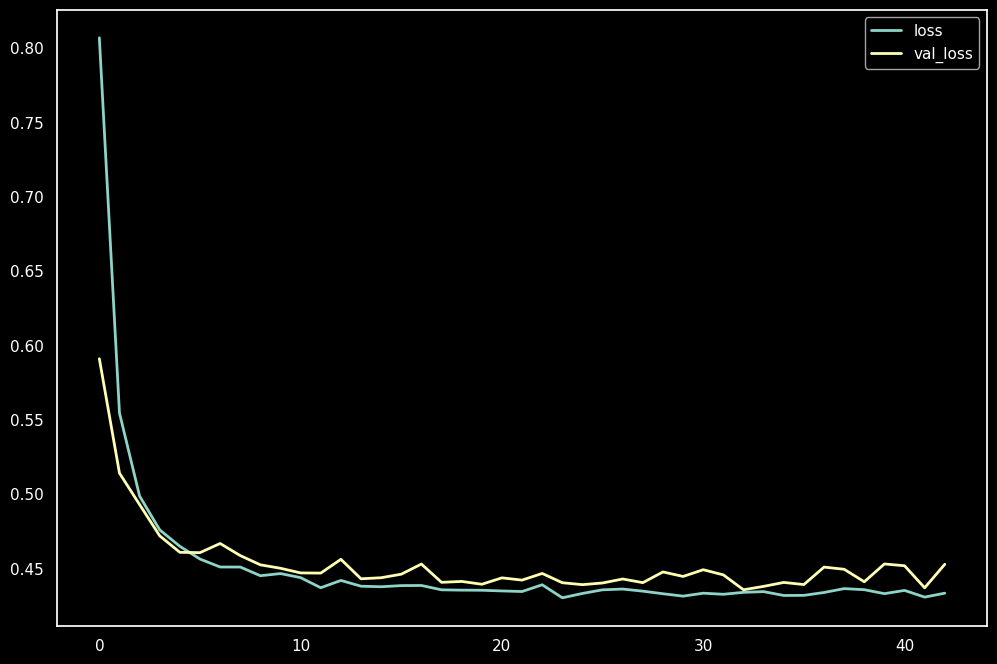

In [ ]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot(figsize=(12,8), linewidth=2);

In [ ]:
training_score = model.evaluate(X_train,y_train,verbose=0)
test_score = model.evaluate(X_test,y_test,verbose=0)

In [ ]:
# Desempeño
print('Train: ',training_score)
print('Test: ',test_score)

# Calcular el promedio del objetivo
mean_target = np.mean(y_train)

# Calcular el MSE del promedio (línea base)
baseline_mse = np.mean((y_test - mean_target) ** 2)

print(f'Baseline MSE: {baseline_mse}')

Train:  0.40541917085647583
Test:  0.45290955901145935
Baseline MSE: 1.0843023161139103


In [ ]:
test_predictions = model.predict(X_test)
test_predictions.shape

131/131 [==============================] - 0s 1ms/step


(4174, 1)

In [ ]:
test_predictions

array([[-0.07412734],
       [ 0.6625557 ],
       [ 1.7116913 ],
       ...,
       [-0.0418274 ],
       [ 0.04697403],
       [ 0.00907523]], dtype=float32)

In [ ]:
y_test = y_test.reset_index(drop=True)

In [ ]:
test_predictions_df = pd.DataFrame(test_predictions, columns=['Predictions'])
result_df = pd.concat([y_test, test_predictions_df], axis=1)

In [ ]:
result_df

,price,Predictions
0,-0.54816,-0.07413
1,1.32220,0.66256
2,1.96934,1.71169
3,0.74613,0.34944
4,-1.12423,-0.49802
...,...,...
4169,-0.64916,-0.33782
4170,0.60398,0.17700
4171,-0.84742,-0.04183
4172,0.34961,0.04697


In [ ]:
y_pred_original = scaler_y.inverse_transform(test_predictions_df)
y_test_original = scaler_y.inverse_transform(y_test)

In [ ]:
baseline_pred = np.mean(train[target])
baseline_mse = mean_squared_error(test[target], [baseline_pred] * len(test[target]))
print(f'Baseline MSE: {baseline_mse}')

Baseline MSE: 77488827199.01982


In [ ]:
original_mse = mean_squared_error(y_test_original, y_pred_original)
print(f'Original MSE: {original_mse}')

Original MSE: 30536445130.510727


In [ ]:
print(f'Mejoró el MSE en {baseline_mse - original_mse}')

Mejoró el MSE en 46952382068.509094


In [ ]:
import math
raiz_cuadrada = math.sqrt(30536445130.510727)
raiz_cuadrada

174746.80291928299

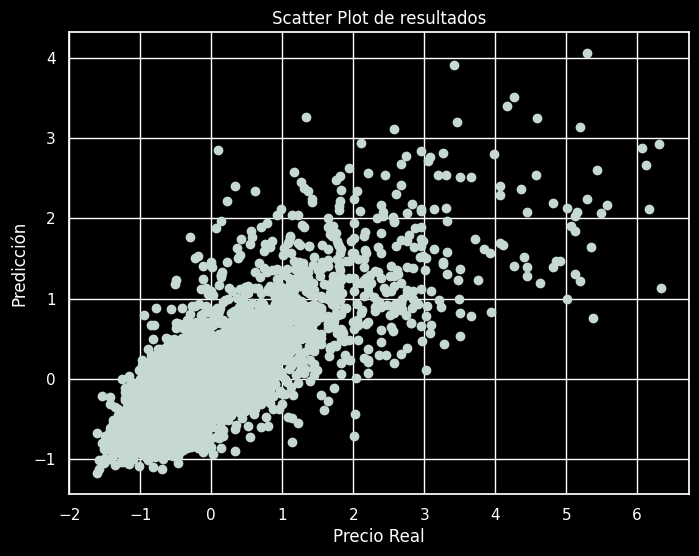

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(result_df['price'], result_df['Predictions'], color='#C5D8D1')
plt.title('Scatter Plot de resultados')
plt.xlabel('Precio Real')
plt.ylabel('Predicción')
plt.grid(True)
plt.show()

# Conclusión

Podemos ver que nuestro Modelo tardó cerca de 43 epocas en entrenarse, pero pudimos ver una mejora en el MSE de  46952382068.509094
<br>
En general nuestro modelo predice bien, teniendo un error promedio de $ 174,746.80